In [37]:
#histgradboost
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion

__file__ = Path('submissions') /  'my_submission1' /  'estimator.py'


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

def _encode(X):
    #cyclical encoding of dates
    X = X.copy()
    year_norm = 2 * np.pi * X['date'].dt.year / X['date'].dt.year.max()
    month_norm = 2 * np.pi * X['date'].dt.month / X['date'].dt.month.max()
    day_norm = 2 * np.pi * X['date'].dt.day / X['date'].dt.day.max()
    weekday_norm = 2 * np.pi * X['date'].dt.weekday / X['date'].dt.weekday.max()
    hour_norm = 2 * np.pi * X['date'].dt.hour / X['date'].dt.hour.max()
    X.loc[:, 'year_sin'] = np.sin(year_norm)
    X.loc[:, 'year_cos'] = np.cos(year_norm)
    X.loc[:, 'month_sin'] = np.sin(month_norm)
    X.loc[:, 'month_cos'] = np.cos(month_norm)
    X.loc[:, 'day_sin'] = np.sin(day_norm)
    X.loc[:, 'day_cos'] = np.cos(day_norm)
    X.loc[:, 'weekday_sin'] = np.sin(weekday_norm)
    X.loc[:, 'weekday_cos'] = np.cos(weekday_norm)
    X.loc[:, 'hour_sin'] = np.sin(hour_norm)
    X.loc[:, 'hour_cos'] = np.cos(hour_norm)
    #encode dates
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour
    X.loc[:, 'is_weekend'] = np.where(X['weekday'].isin([5,6]), 1,0)
    X.loc[:, 'workday'] = np.where(X['weekday'].isin([0,4]), 1,0)
    return X.drop(columns=["date"]) 
 
def _merge_external_data(X):
    file_path = Path(__file__).parent / 'external_data.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    X = pd.merge_asof(X.sort_values('date'), df_ext[['date', 't', 'ff', 'u', 'brent', 'holidays', 'curfew', 'rush hour', 'Taux', 'workplace', 'transit']].sort_values('date'), on='date')
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    return X



def get_estimator():
    #columns
    date_encoder = FunctionTransformer(_encode)
    #cycl_cols = ['month_sin', 'month_cos','day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']
    date_cols = ['year', 'day']
 
    categorical_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    categorical_cols = ["site_name", "counter_name"]
    binary_cols =  ['curfew', 'rush hour']
    numeric_cols = ['Taux', 't', 'brent', 'ff', 'u', 'transit']
 
    #preprocessor
        
    preprocessor = ColumnTransformer(
        [
            ('date', 'passthrough', date_cols),
            #('cycl', 'passthrough', cycl_cols),
            ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
            ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
            ('holiday', 'passthrough', binary_cols),  
            ('cat', categorical_encoder, categorical_cols),
            ('numeric', 'passthrough', numeric_cols)
        ]
    )
    hour_workday_interaction = make_pipeline(
        ColumnTransformer(
            [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
            ("weekday", FunctionTransformer(lambda x: x == "True"), ["workday"]),
            ]
        ),
        PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
    )

    regressor = lgb.LGBMRegressor(n_estimators=275, num_leaves=150, importance_type='gain', random_state=0)

    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        date_encoder,
        FeatureUnion(
            [('without', preprocessor),
             ('with', hour_workday_interaction)
             ]
        ),
        regressor)

    return pipe

In [38]:
import problem

data = pd.read_parquet(Path('data') / 'train.parquet')
weekday_norm = 2 * np.pi * data['date'].dt.weekday / data['date'].dt.weekday.max()
weekday_norm = pd.DataFrame(weekday_norm)
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

<AxesSubplot:title={'center':'Different hourly values between counters'}, xlabel='date'>

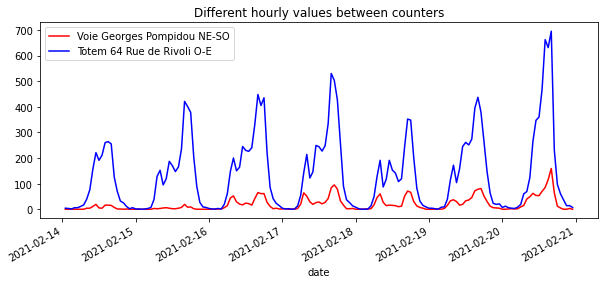

In [39]:

fig, ax = plt.subplots(figsize=(10, 4))

mask1 = ((data['counter_name'] == 'Voie Georges Pompidou NE-SO')
        & (data['date'] > pd.to_datetime('2021/02/14'))
        & (data['date'] < pd.to_datetime('2021/02/21')))

mask2 = ((data['counter_name'] == 'Totem 64 Rue de Rivoli O-E')
        & (data['date'] > pd.to_datetime('2021/02/14'))
        & (data['date'] < pd.to_datetime('2021/02/21')))

data[mask1].plot(x='date', y='bike_count', ax=ax, title='Different hourly values between counters', color='r', label='Voie Georges Pompidou NE-SO')
data[mask2].plot(x='date', y='bike_count', ax=ax, color='b', label='Totem 64 Rue de Rivoli O-E')

<AxesSubplot:title={'center':'Different weekly values between counters'}, xlabel='date'>

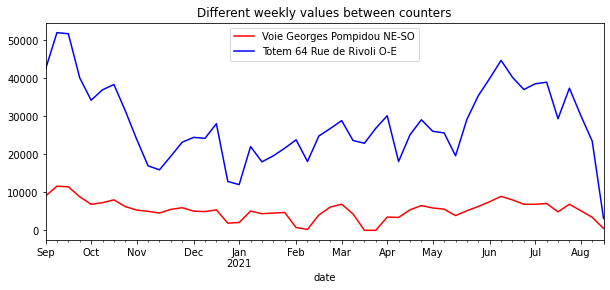

In [40]:
fig, ax = plt.subplots(figsize=(10, 4))

mask1 = data['counter_name'] == 'Voie Georges Pompidou NE-SO'
mask2 = data['counter_name'] == 'Totem 64 Rue de Rivoli O-E'

data[mask1].groupby(pd.Grouper(freq='1w', key='date')).sum().plot(
    y='bike_count', ax=ax, color='r', title='Different weekly values between counters',
    label='Voie Georges Pompidou NE-SO')
data[mask2].groupby(pd.Grouper(freq='1w', key='date')).sum().plot(
    y='bike_count', ax=ax, color='b', label='Totem 64 Rue de Rivoli O-E')

In [41]:
data.loc[data['log_bike_count'] == 0, 'counter_name'].value_counts()

28 boulevard Diderot E-O                           2862
Face au 40 quai D'Issy SO-NE                       2420
20 Avenue de Clichy NO-SE                          2375
20 Avenue de Clichy SE-NO                          2353
Face au 40 quai D'Issy NE-SO                       2169
Pont des Invalides S-N                             1580
152 boulevard du Montparnasse O-E                  1142
152 boulevard du Montparnasse E-O                  1077
90 Rue De Sèvres SO-NE                             1040
Voie Georges Pompidou NE-SO                         900
6 rue Julia Bartet SO-NE                            889
Pont de Bercy SO-NE                                 873
Face au 8 avenue de la porte de Charenton NO-SE     863
18 quai de l'Hôtel de Ville NO-SE                   834
Face au 70 quai de Bercy S-N                        800
Face au 4 avenue de la porte de Bagnolet O-E        783
Pont Charles De Gaulle SO-NE                        760
Face au 8 avenue de la porte de Charenton SE-NO 

In [42]:
#histgrad
#columns
date_encoder = FunctionTransformer(_encode)
#cycl_cols = ['month_sin', 'month_cos','day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']
date_cols = ['year', 'day']

categorical_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
categorical_cols = ["site_name", "counter_name"]
binary_cols =  ['curfew', 'rush hour']
numeric_cols = ['Taux', 't', 'brent', 'ff', 'u', 'transit']

#preprocessor

preprocessor = ColumnTransformer(
[
    ('date', 'passthrough', date_cols),
    #('cycl', 'passthrough', cycl_cols),
    ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
    ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
    ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ('holiday', 'passthrough', binary_cols),  
    ('cat', categorical_encoder, categorical_cols),
    ('numeric', 'passthrough', numeric_cols)
]
)
hour_workday_interaction = make_pipeline(
ColumnTransformer(
    [
    ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ("weekday", FunctionTransformer(lambda x: x == "True"), ["workday"]),
    ]
),
PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

regressor = HistGradientBoostingRegressor(random_state=0, max_leaf_nodes=300, max_iter=150)

pipe = make_pipeline(
FunctionTransformer(_merge_external_data, validate=False),
date_encoder,
FeatureUnion(
    [('without', preprocessor),
     ('with', hour_workday_interaction)
     ]
),
regressor)


In [43]:
#columns
date_encoder = FunctionTransformer(_encode)
#cycl_cols = ['month_sin', 'month_cos','day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']
date_cols = ['year', 'day']

categorical_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
categorical_cols = ["site_name", "counter_name"]
binary_cols =  ['curfew', 'rush hour']
numeric_cols = ['Taux', 't', 'brent', 'ff', 'u', 'transit']

#preprocessor

preprocessor = ColumnTransformer(
[
    ('date', 'passthrough', date_cols),
    #('cycl', 'passthrough', cycl_cols),
    ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
    ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
    ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ('holiday', 'passthrough', binary_cols),  
    ('cat', categorical_encoder, categorical_cols),
    ('numeric', 'passthrough', numeric_cols)
]
)
hour_workday_interaction = make_pipeline(
ColumnTransformer(
    [
    ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ("weekday", FunctionTransformer(lambda x: x == "True"), ["workday"]),
    ]
),
PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

regressor = lgb.LGBMRegressor(n_estimators=275, num_leaves=150, importance_type='gain', random_state=0)

pipe_lgbm = make_pipeline(
FunctionTransformer(_merge_external_data, validate=False),
date_encoder,
FeatureUnion(
    [('without', preprocessor),
     ('with', hour_workday_interaction)
     ]
),
regressor)


In [44]:
#xg
from sklearn.kernel_approximation import Nystroem

date_encoder = FunctionTransformer(_encode)
#cycl_cols = ['month_sin', 'month_cos','day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']
date_cols = ['year', 'day']

categorical_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
categorical_cols = ["site_name", "counter_name"]
binary_cols =  ['curfew', 'rush hour']
numeric_cols = ['Taux', 't', 'brent', 'ff', 'u', 'transit']

#preprocessor

preprocessor = ColumnTransformer(
[
    ('date', 'passthrough', date_cols),
    #('cycl', 'passthrough', cycl_cols),
    ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
    ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
    ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ('holiday', 'passthrough', binary_cols),  
    ('cat', categorical_encoder, categorical_cols),
    ('numeric', 'passthrough', numeric_cols)
]
)
hour_workday_interaction = make_pipeline(
ColumnTransformer(
    [
    ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ("weekday", FunctionTransformer(lambda x: x == "True"), ["workday"]),
    ]
),
PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

regressor = xgb.XGBRegressor()

pipe_xgb = make_pipeline(
FunctionTransformer(_merge_external_data, validate=False),
date_encoder,
FeatureUnion(
    [('without', preprocessor),
     ('with', hour_workday_interaction)
     ]
), 
Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
regressor)

In [44]:
pipe.fit(X_train, y_train)
pipe_lgbm.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ckunt\anaconda3\envs\bikes-ramp\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ckunt\AppData\Local\Temp/ipykernel_12272/2801307320.py", line 3, in <module>
    pipe_xgb.fit(X_train, y_train)
  File "C:\Users\ckunt\anaconda3\envs\bikes-ramp\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\ckunt\anaconda3\envs\bikes-ramp\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\ckunt\anaconda3\envs\bikes-ramp\lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\ckunt\anaconda3\envs\bikes-ramp\lib\site-packages\sklearn\pipeline.py", line 891, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "C:\Users\ckunt

TypeError: object of type 'NoneType' has no len()

In [45]:
mask_pred = ((X_test['counter_name'] == 'Voie Georges Pompidou NE-SO')
        & (X_test['date'] > pd.to_datetime('2021/09/01'))
        & (X_test['date'] < pd.to_datetime('2021/09/08')))


df_viz = X_test.loc[mask_pred].copy()
df_viz['bike_count'] = np.exp(y_test[mask_pred.values]) - 1
df_viz['bike_count (hist grad)'] = np.exp(pipe.predict(X_test[mask_pred])) -  1

df_viz2 = X_test.loc[mask_pred].copy()
df_viz2['bike_count'] = np.exp(y_test[mask_pred.values]) - 1
df_viz2['bike_count (lgbm)'] = np.exp(pipe_lgbm.predict(X_test[mask_pred])) -  1

df_viz3 = X_test.loc[mask_pred].copy()
df_viz3['bike_count'] = np.exp(y_test[mask_pred.values]) - 1
df_viz3['bike_count (xgb)'] = np.exp(pipe_xgb.predict(X_test[mask_pred])) -  1

ERROR! Session/line number was not unique in database. History logging moved to new session 143


NotFittedError: This Nystroem instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='bike_count', ax=ax)
df_viz.plot(x='date', y='bike_count (hist grad)', ax=ax)
df_viz2.plot(x='date', y='bike_count (lgbm)', ax=ax)
df_viz3.plot(x='date', y='bike_count (xgb)', ax=ax, linestyle='--')
ax.set_title('Predictions with different estimators')
ax.set_ylabel('bike_count')

In [410]:
#histgrad
from sklearn.inspection import permutation_importance
merger = pipe[:2]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipe[2:]
_ = predictor.fit(X_train_augmented, y_train)

In [ ]:
feature_importances = permutation_importance(
    predictor, X_train_augmented[:20000], y_train[:20000], n_repeats=10, random_state=0
)
sorted_idx = feature_importances.importances_mean.argsort()


In [ ]:
#lgbm
merger = pipe_lgbm[:2]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipe_lgbm[2:]
_ = predictor.fit(X_train_augmented, y_train)
feature_importances = permutation_importance(
    predictor, X_train_augmented[:20000], y_train[:20000], n_repeats=10, random_state=0
)
sorted_idx = feature_importances.importances_mean.argsort()


In [401]:
#lgbm
merger = pipe_xgb[:2]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipe_xgb[2:]
_ = predictor.fit(X_train_augmented, y_train)
feature_importances = permutation_importance(
    predictor, X_train_augmented[:20000], y_train[:20000], n_repeats=10, random_state=0
)
sorted_idx = feature_importances.importances_mean.argsort()

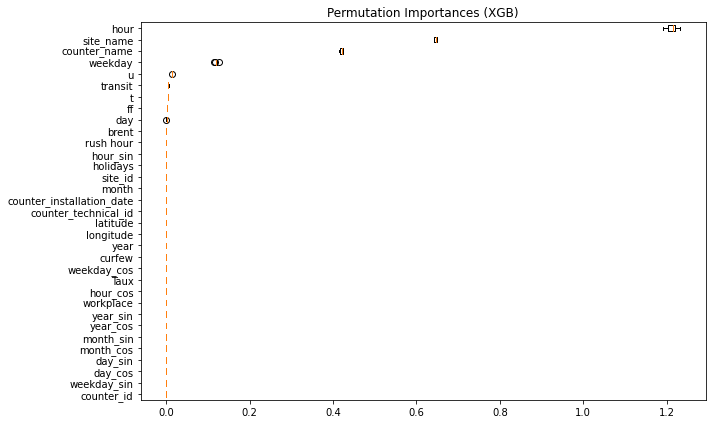

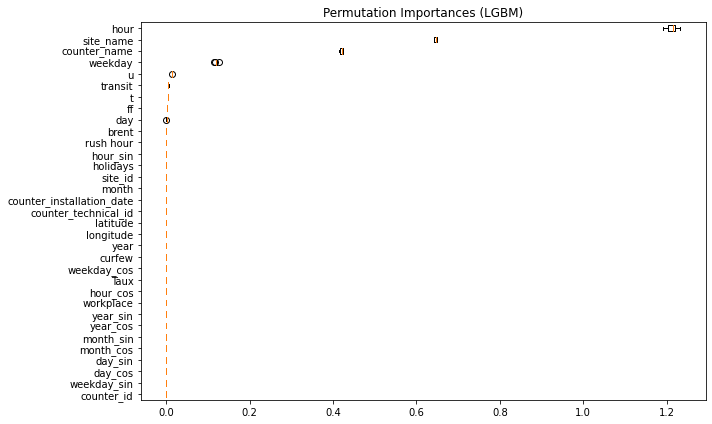

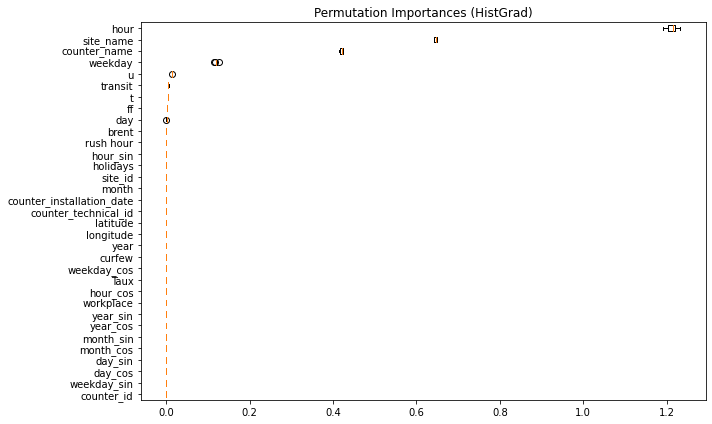

In [402]:
#xgb
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (XGB)")
fig.tight_layout()
plt.show()

#lgbm
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (LGBM)")
fig.tight_layout()
plt.show()

#histgrad
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (HistGrad)")
fig.tight_layout()
plt.show()